# Ontdekken van gek webverkeer
Het doel van dit project is het vinden van anomalieën in het webverkeer uit verschillende regio's. Idealiter wil de IT-afdeling weten wanneer we pieken in de gegevens zien, zodat ze preventief het webbeveiligingsteam kunnen inzetten. Ze denken dat als het aantal hits boven de 190 komt, het een goede indicator is dat er iets vreemds gebeurt.

<p><strong>Goal</strong> - Ontdek anomalieën in webverkeer</p>
<p><strong>Data</strong> - Web verkeer per hosting region in de tijd</p>
<p><strong>Task</strong> - Unsupervised anomaly detection</p>

# 1. Import Data

In [1]:
# importeren
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# importeren van data
df = pd.read_csv('dataset.csv')

In [3]:
# check 
df.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
0,1/1/2021,123.594462,179.799106,142.051377,165.898948,211.796438,140.574596
1,2/1/2021,96.913589,142.312297,98.873977,160.450595,126.403444,146.323197
2,3/1/2021,127.769080,205.521667,102.443675,127.585609,243.919837,211.321143
3,4/1/2021,232.383608,157.833057,151.695219,184.958764,112.802699,169.354083
4,5/1/2021,121.971639,166.400354,139.208040,105.576656,91.234096,221.821293


# 2. Splitten van dat om Data Snooping Bias de voorkomen

In [4]:
# importeren
from sklearn.model_selection import train_test_split

In [5]:
# splitten
train, test = train_test_split(df, test_size=0.3, random_state=1234)

In [6]:
# check
print(train.shape)
print(test.shape)

(368, 7)
(158, 7)


In [7]:
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,13/3/2022,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,16/4/2022,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,6/6/2022,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,29/4/2021,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,12/6/2021,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


In [8]:
test.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
261,19/9/2021,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842
425,2/3/2022,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772
21,22/1/2021,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156
329,26/11/2021,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199
310,7/11/2021,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637


# 3. Exploratory Data Analysis (EDA)

## Algemene EDA

In [9]:
# type
train.dtypes

Date         object
Region 1    float64
Region 2    float64
Region 3    float64
Region 4    float64
Region 5    float64
Region 6    float64
dtype: object

In [10]:
# null values
train.isnull().sum()

Date        0
Region 1    0
Region 2    0
Region 3    0
Region 4    0
Region 5    0
Region 6    0
dtype: int64

In [11]:
# statistisch
train.describe()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,151.128974,167.734819,155.862138,157.182245,161.480763,153.131734
std,51.369861,95.484190,80.129220,71.864944,91.850797,52.667582
min,11.184334,7.461471,-8.153494,-9.810526,-19.235141,-9.713714
25%,118.151654,126.804343,115.367657,121.458658,117.213061,119.523299
50%,150.579649,152.687679,147.487873,152.710155,151.404897,150.309562
75%,183.908133,192.515750,182.791165,188.930369,184.605039,185.003355
max,505.000000,784.000000,782.000000,723.000000,759.000000,404.000000


In [12]:
# 1.5 IQR rule van Region 4, checken van outlier
188+1.5*(188-121)

288.5

In [13]:
# 1.5 IQR rule van Region 2, checken van outlier
192+1.5*(192-126)

291.0

## Plot Distributions

In [14]:
# importern
from pandas.plotting import scatter_matrix

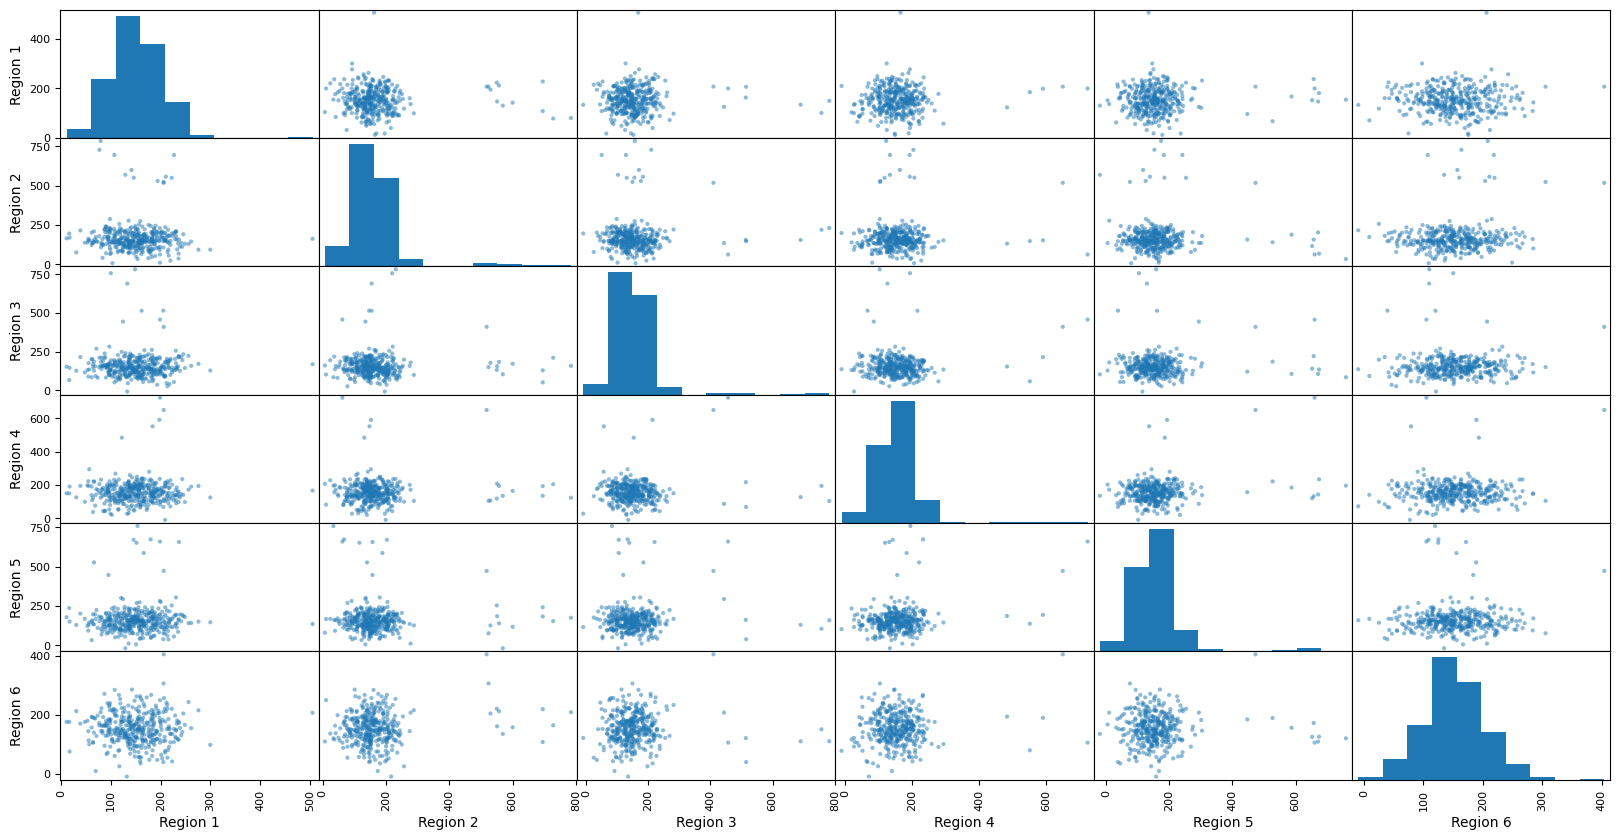

In [15]:
# plot scatter matrix
scatter_matrix(train, figsize=(20,10))
plt.show()

## Fix Date Column met juiste datatype

In [16]:
# type
train.dtypes

Date         object
Region 1    float64
Region 2    float64
Region 3    float64
Region 4    float64
Region 5    float64
Region 6    float64
dtype: object

In [17]:
# zet om naar datetime
train['Date'] = pd.to_datetime(train['Date'], format="%d/%m/%Y")

In [18]:
# check type
train.dtypes

Date        datetime64[ns]
Region 1           float64
Region 2           float64
Region 3           float64
Region 4           float64
Region 5           float64
Region 6           float64
dtype: object

## Visualiseer anomalieën?

In [19]:
# importeren
import seaborn as sns

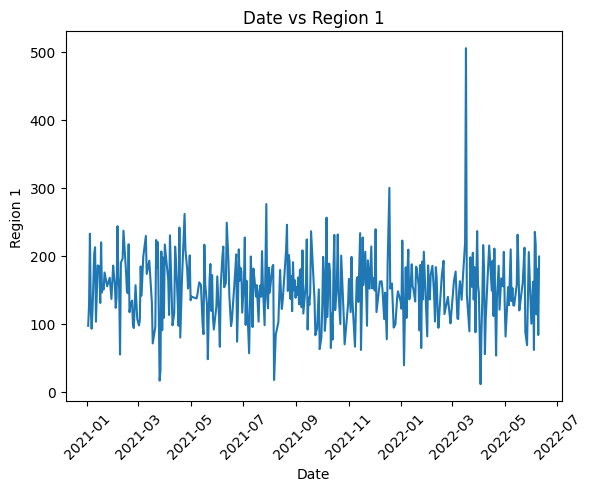

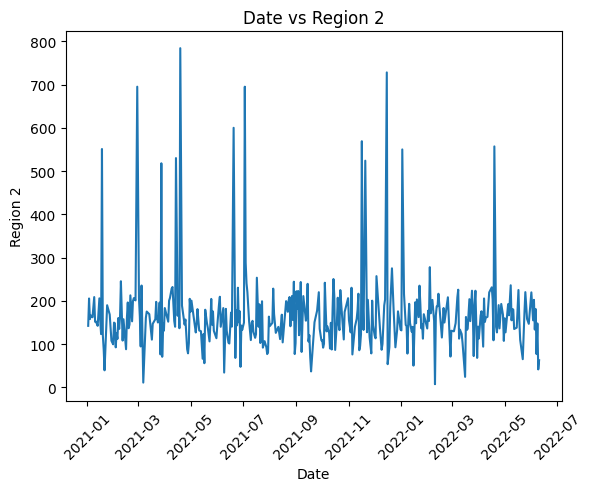

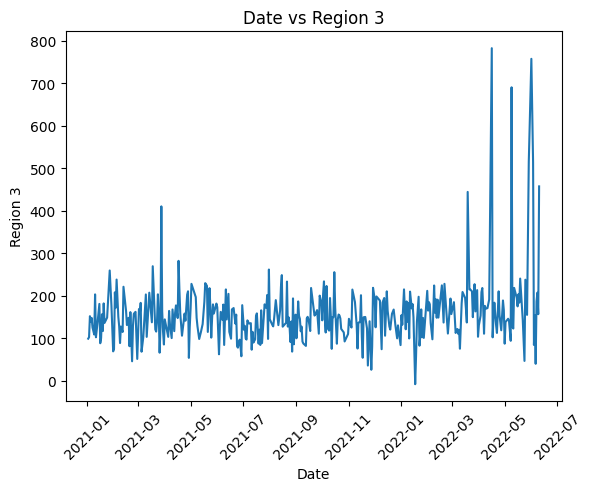

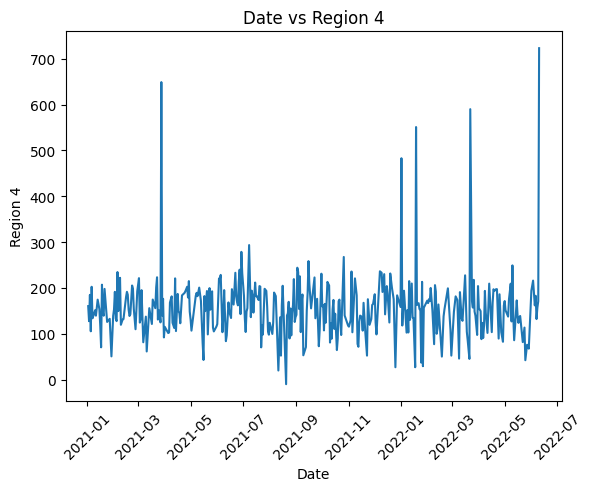

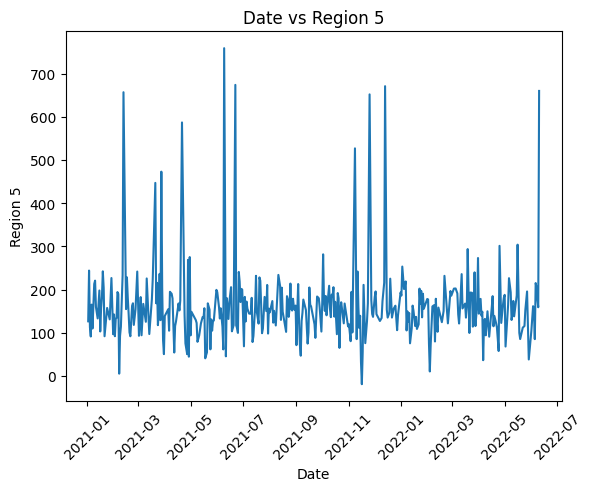

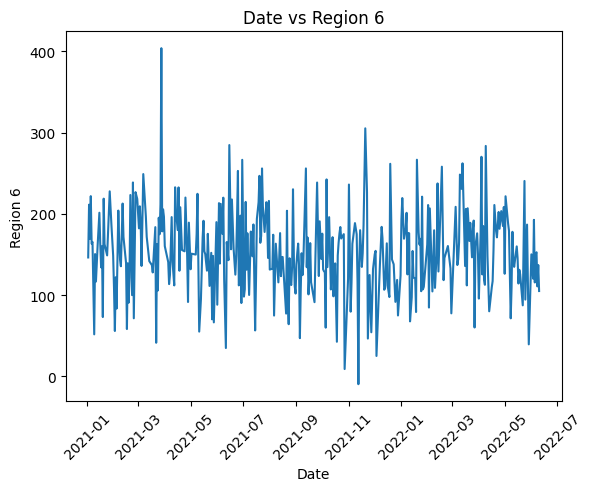

In [20]:
# plot 
for col in train.columns[1:]:
    sns.lineplot(
        data=train,
        x='Date',
        y=col
    ).set_title(f'Date vs {col}')
    plt.xticks(rotation=45)
    plt.show()

## Hebben spikes een relatie met tijd?

In [21]:
# FE - creëer binary flag als het boven de 250 gaat
train['spike'] = (train[train.columns[1:]] >= 250).any(axis=1).astype(int)

In [22]:
# check
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0


In [23]:
# check
train[train['spike'] == 1].head(10)

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
323,2021-11-20,205.861833,524.000000,149.952931,104.507053,75.771865,305.307234,1
278,2021-10-06,255.972485,129.492414,222.723926,171.396058,140.339710,242.433164,1
298,2021-10-26,109.370524,110.805624,113.617779,267.659334,121.693990,175.050036,1
348,2021-12-15,77.246825,728.000000,210.207296,204.098908,153.194283,163.715139,1
351,2021-12-18,299.667941,93.189146,127.818161,124.721384,146.281411,97.601776,1
108,2021-04-19,79.671701,784.000000,157.779755,123.046970,174.343955,208.137942,1
518,2022-06-03,161.827944,155.094149,514.000000,216.114283,161.383222,120.252722,1
458,2022-04-04,87.140612,175.927544,208.332290,88.432124,139.711754,270.290167,1


In [24]:
# maak date features
train['day'] = train['Date'].dt.dayofweek
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year
train['monthstart'] = train['Date'].dt.is_month_start
train['monthend'] = train['Date'].dt.is_month_end
train['quarterstart'] = train['Date'].dt.is_quarter_start
train['quartereind'] = train['Date'].dt.is_quarter_end

In [25]:
# check
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike,day,month,year,monthstart,monthend,quarterstart,quartereind
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1,6,3,2022,False,False,False,False
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1,5,4,2022,False,False,False,False
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0,0,6,2022,False,False,False,False
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0,3,4,2021,False,False,False,False
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0,5,6,2021,False,False,False,False


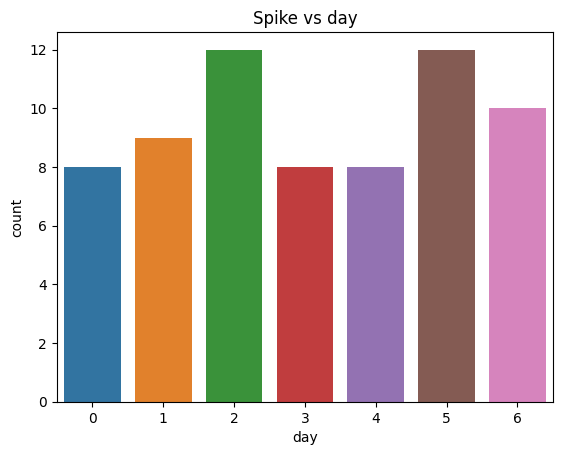

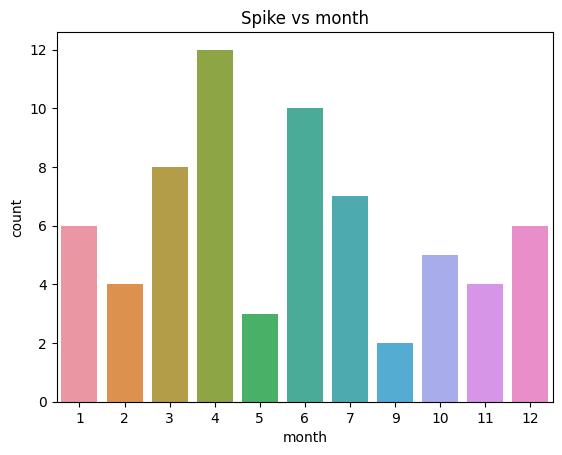

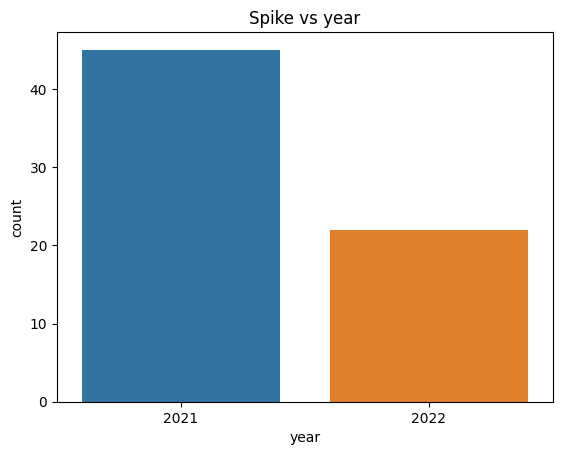

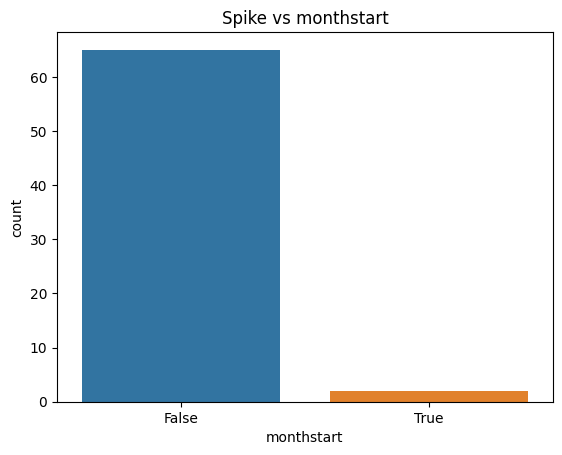

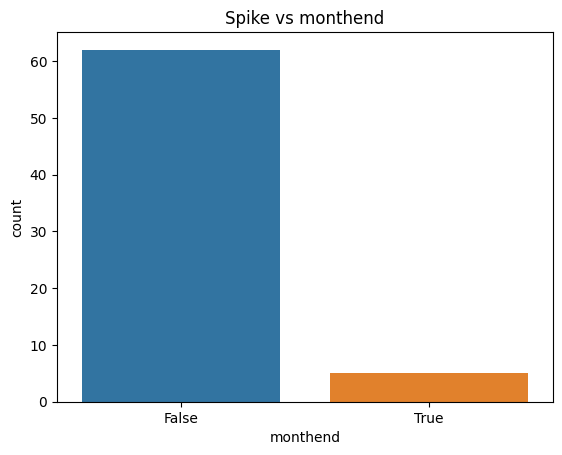

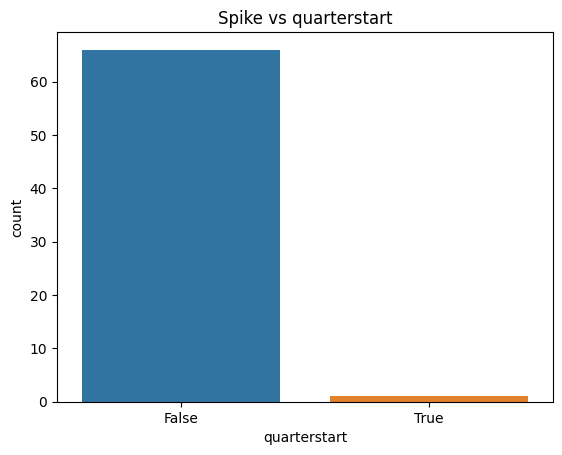

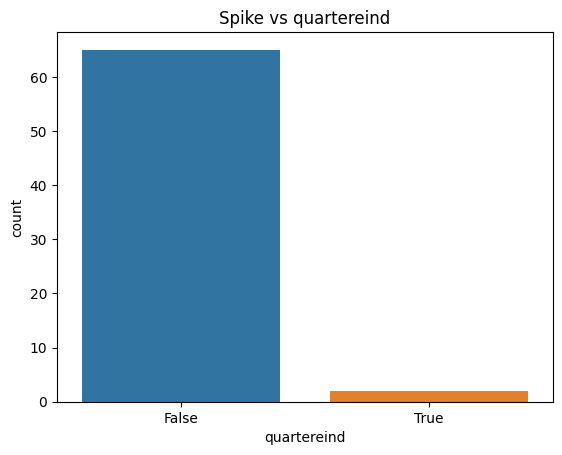

In [26]:
# visualiseer met nieuwe features
time_cols = ['day', 'month', 'year', 'monthstart', 'monthend', 'quarterstart', 'quartereind']
for col in time_cols:
    sns.countplot(
        data=train[train['spike']==1],
        x=col
    ).set_title(f'Spike vs {col}')
    plt.show()

In [27]:
# drop time gerelateerd kolommen
train = train.drop(time_cols, axis=1)

In [28]:
# check
train.head()

,Date,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
436,2022-03-13,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418,1
470,2022-04-16,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732,1
521,2022-06-06,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250,0
118,2021-04-29,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559,0
162,2021-06-12,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077,0


## Analyse Correlation

In [29]:
# correlatie
train.select_dtypes(include=[float, int]).corr()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,spike
Region 1,1.000000,-0.021998,0.016817,0.058301,0.043939,-0.000046,0.126999
Region 2,-0.021998,1.000000,0.005645,0.035998,-0.030305,0.131186,0.363026
Region 3,0.016817,0.005645,1.000000,0.081737,0.046921,0.015633,0.300963
Region 4,0.058301,0.035998,0.081737,1.000000,0.231511,0.074267,0.237912
Region 5,0.043939,-0.030305,0.046921,0.231511,1.000000,0.012228,0.341970
Region 6,-0.000046,0.131186,0.015633,0.074267,0.012228,1.000000,0.224595
spike,0.126999,0.363026,0.300963,0.237912,0.341970,0.224595,1.000000


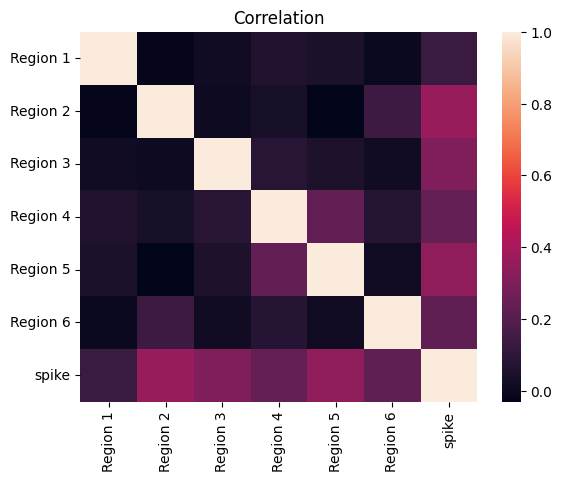

In [30]:
# heatmap
sns.heatmap(train.select_dtypes(include=[float, int]).corr()).set_title('Correlation')
plt.show()    

# 4. Data Preprocessing

## Drop Date en Voeg Spike toe aan Test Set

In [34]:
# drop kolommen
X_train = train.drop(['Date', 'spike'], axis=1)
X_test = test.drop(['Date'], axis=1)

In [35]:
# check
X_train.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
436,158.992329,103.595983,208.664219,128.352544,156.223776,262.221418
470,148.618546,231.350464,782.000000,103.716711,158.796185,109.755732
521,217.863557,181.198188,39.779913,182.967647,214.980495,150.621250
118,164.808437,102.842019,53.699011,214.959871,44.470706,189.192559
162,248.582870,130.898347,143.994442,96.685363,180.243516,165.263077


In [36]:
# check twee
X_test.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637


# 5. Modelling

## Pipelines

In [37]:
# importeren
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [38]:
# importeren
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [42]:
# pipelines aanmaken
pipelines = {
    'iso':make_pipeline(StandardScaler(), IsolationForest(n_estimators=300, random_state=1234)),
    'lof':make_pipeline(StandardScaler(), LocalOutlierFactor(n_neighbors=20, novelty=True)),
    'svm':make_pipeline(StandardScaler(), OneClassSVM())
}

In [43]:
# check
pipelines['iso']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('isolationforest',
                 IsolationForest(n_estimators=300, random_state=1234))])

## Train Models

In [44]:
# train alle models
fit_models = {}
for algo, model in pipelines.items():
    print(f'Training {algo}')
    model.fit(X_train)
    fit_models[algo] = model

Training iso
Training lof
Training svm


# 6. Evaluate Models

## Scoring Matrix

In [46]:
# resultaten (van predictions per model) in df zetten
result_df = X_test.copy()
for algo, model in fit_models.items():
    res = model.predict(X_test)
    result_df[algo] = res

In [47]:
# check
result_df.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772,1,1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199,1,1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1


In [49]:
# waar labelt iso outliers
result_df[result_df['iso']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
327,179.619650,653.000000,100.155483,67.632703,324.212084,188.883103,-1,-1,-1
347,158.438903,246.000750,481.000000,126.313786,237.314565,133.014314,-1,-1,-1
515,119.088498,145.312179,701.000000,73.094460,111.089097,140.742985,-1,-1,-1
468,112.820924,68.422314,152.338513,148.959091,633.000000,122.942972,-1,-1,-1
517,236.624619,188.581893,649.000000,196.377738,98.529104,140.321670,-1,-1,-1
514,204.922210,209.984769,660.000000,125.454150,173.482150,195.324457,-1,-1,-1
123,126.402378,288.561035,503.000000,133.167646,170.421123,270.344075,-1,-1,-1


In [50]:
# waar labelt lof outliers
result_df[result_df['lof']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1
327,179.619650,653.000000,100.155483,67.632703,324.212084,188.883103,-1,-1,-1
512,216.038471,206.225560,187.019075,300.423898,117.290475,223.672373,1,-1,-1
347,158.438903,246.000750,481.000000,126.313786,237.314565,133.014314,-1,-1,-1
515,119.088498,145.312179,701.000000,73.094460,111.089097,140.742985,-1,-1,-1
468,112.820924,68.422314,152.338513,148.959091,633.000000,122.942972,-1,-1,-1
181,239.112193,456.000000,206.338388,146.578865,141.358126,151.583738,1,-1,-1
111,150.538307,105.232372,-6.073812,97.365668,131.213726,51.170400,1,-1,-1
517,236.624619,188.581893,649.000000,196.377738,98.529104,140.321670,-1,-1,-1
514,204.922210,209.984769,660.000000,125.454150,173.482150,195.324457,-1,-1,-1


In [51]:
# waar labelt svm outliers
result_df[result_df['svm']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1
...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1


In [52]:
# maak spike kollom
result_df['spike'] = (result_df[result_df.columns[0:6]] >=250).any(axis=1).astype(int)
# resultaat zelfde maken als algo's, dus 1 en -1
result_df['spike'] = result_df['spike'].replace(1,-1).replace(0,1)

In [53]:
# check
result_df.head()

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm,spike
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1,1
425,155.830214,137.432916,165.569703,110.725701,123.453509,159.390772,1,1,1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1,1
329,189.518384,134.788869,161.219281,85.183524,124.251407,157.197199,1,1,1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1,1


In [55]:
# waar labelt iso outliers
result_df[result_df['svm']==-1]

,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,iso,lof,svm,spike
261,174.982473,188.073353,212.564889,227.348706,90.856875,228.446842,1,1,-1,1
21,116.924514,83.170321,83.832043,131.375901,213.164326,71.697156,1,1,-1,1
310,136.550482,158.632527,234.408947,168.732082,173.253947,69.403637,1,1,-1,1
66,89.879803,201.130424,134.432471,281.407783,159.461995,230.804372,1,1,-1,-1
124,129.499511,462.000000,26.431366,162.445374,202.411825,157.847851,1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...
43,242.058629,156.975012,142.625262,130.416922,149.543268,174.722216,1,1,-1,1
115,145.231810,141.420973,218.935651,50.286454,138.589165,164.643271,1,1,-1,1
93,125.446549,45.943054,136.094739,148.353361,110.219904,215.959099,1,1,-1,1
362,142.876137,193.744128,111.953142,101.922023,263.122229,89.099177,1,1,-1,-1


## Proxy Performance

In [56]:
# importeren
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [61]:
# bereken metrics
for key in fit_models.keys():
    ytrue = result_df['spike'].replace(1,0).replace(-1,1)
    yhat = result_df[key].replace(1,0).replace(-1,1)
    precision = precision_score(ytrue, yhat)
    recall = recall_score(ytrue, yhat)
    f1 = f1_score(ytrue, yhat)
    print(f'{key}-- Precision:{precision}, Recall:{recall}, F1:{f1}')

iso-- Precision:1.0, Recall:0.30434782608695654, F1:0.4666666666666667
lof-- Precision:0.9090909090909091, Recall:0.43478260869565216, F1:0.5882352941176471
svm-- Precision:0.26582278481012656, Recall:0.9130434782608695, F1:0.4117647058823529


In [ ]:
# set y voor lof
ytrue = result_df['spike']
yhat = result_df['lof']

In [58]:
# confusion matrix
confusion_matrix(ytrue, yhat, labels=[-1,1])

array([[77, 58],
       [ 2, 21]], dtype=int64)

In [59]:
# set y voor iso
ytrue = result_df['spike']
yhat = result_df['iso']

In [60]:
# confusion matrix 
confusion_matrix(ytrue, yhat, labels=[-1,1])

array([[  7,  16],
       [  0, 135]], dtype=int64)

## Predictions

In [63]:
# predict
fit_models['lof'].predict(X_test)

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

## Save Models

In [65]:
# importeren
import joblib

In [66]:
# save lof model
joblib.dump(fit_models['lof'], 'localoutlierfactor.joblib')

['localoutlierfactor.joblib']

# 7. Bouwen van Gradio Checker APP

## Setup Gradio

In [67]:
!pip install gradio

     ---------------------------------------- 15.8/15.8 MB 6.0 MB/s eta 0:00:00
  Using cached aiohttp-3.8.4-cp311-cp311-win_amd64.whl (317 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 145.4/145.4 kB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 71.5/71.5 kB ? eta 0:00:00
     ------------------------------------- 199.8/199.8 kB 11.8 MB/s eta 0:00:00
     ---------------------------------------- 50.5/50.5 kB ? eta 0:00:00
     ------------------------------------- 205.0/205.0 kB 12.2 MB/s eta 0:00:00
     ---------------------------------------- 45.7/45.7 kB ? eta 0:00:00
     ---------------------------------------- 101.4/101.4 kB ? eta 0:00:00
  Using cached multidict-6.0.4-cp311-cp311-win_amd64.whl (28 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached yarl-1.8.2-cp311-cp311-win_amd64.whl (55 kB)
  Using cached frozenlist-1.3.3-cp

  DEPRECATION: ffmpy is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
!pip show gradio

Name: gradio
Version: 3.23.0
Summary: Python library for easily interacting with trained machine learning models
Home-page: 
Author: 
Author-email: Abubakar Abid <team@gradio.app>, Ali Abid <team@gradio.app>, Ali Abdalla <team@gradio.app>, Dawood Khan <team@gradio.app>, Ahsen Khaliq <team@gradio.app>, Pete Allen <team@gradio.app>, Ömer Faruk Özdemir <team@gradio.app>
License: 
Location: C:\Users\stefa\Documents\Fullstack ML\venv\Lib\site-packages
Requires: aiofiles, aiohttp, altair, fastapi, ffmpy, fsspec, httpx, huggingface-hub, huggingface-hub, jinja2, markdown-it-py, markupsafe, matplotlib, mdit-py-plugins, numpy, orjson, pandas, pillow, pydantic, pydub, python-multipart, pyyaml, requests, semantic-version, typing-extensions, uvicorn, websockets
Required-by: 


In [73]:
# maak predict functie
def predict(region1, region2, region3, region4, region5, region6):
    model = joblib.load('localoutlierfactor.joblib')
    yhat = model.predict(np.array([[region1, region2, region3, region4, region5, region6]]))
    return 'Weird Traffic' if yhat == -1 else 'Normal Traffic'

In [71]:
X_test.iloc[0]

Region 1    174.982473
Region 2    188.073353
Region 3    212.564889
Region 4    227.348706
Region 5     90.856875
Region 6    228.446842
Name: 261, dtype: float64

In [70]:
X_test.iloc[0].tolist()

[174.9824725, 188.0733533, 212.5648887, 227.3487056, 90.85687477, 228.4468416]

In [75]:
# test
predict(*X_test.iloc[0].tolist())

C:\Users\stefa\Documents\Fullstack ML\venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Normal Traffic'

In [76]:
# test 2
predict(*result_df[result_df['lof']==-1][result_df.columns[0:6]].iloc[0].tolist())

C:\Users\stefa\Documents\Fullstack ML\venv\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


'Weird Traffic'

## Bouw en Share Gradio App

In [77]:
# importeren
import gradio as gr

In [81]:
# creëer interface
app = gr.Interface(
    title='Anomalieën in webverkeer ontdekken 🚦',
    fn=predict, 
    inputs=[gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800),gr.Slider(0,800)], 
    outputs='text'
)

In [85]:
# launch
app.launch(auth=("admin_user", "geheim_wachtwoord"), share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f9ca10d9bf3cda61d0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [84]:
app.close()

Closing server running on port: 7860


In [86]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\stefa\Documents\Fullstack ML\venv\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: imbalanced-learn
